In [1]:
pip install matplotlib pandas pulp

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\fal23\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulp\pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


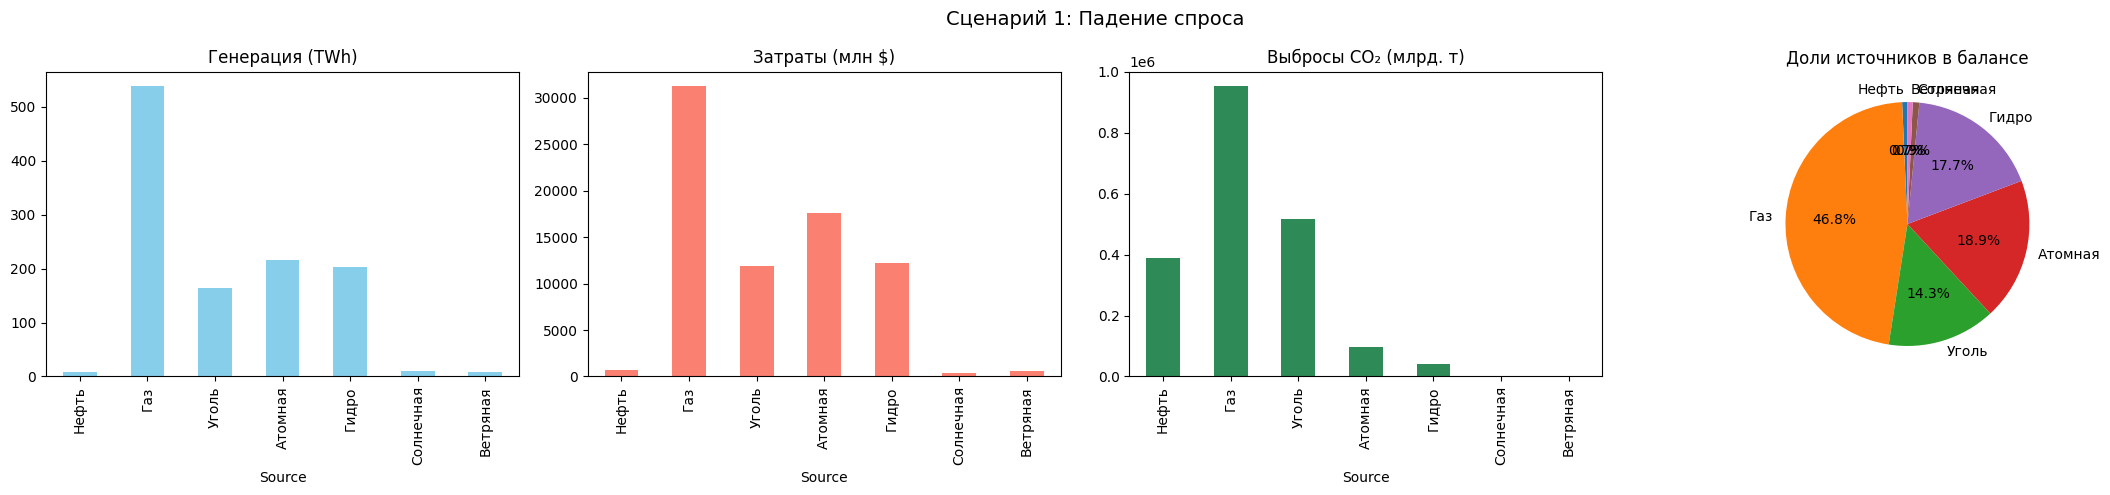


📋 Сценарий 1: Падение спроса
              TWh  Cost (MEUR)  Share (%)
Source                                   
Нефть        8.00       704.00       0.70
Газ        538.73     31246.48      46.85
Уголь      165.00     11880.00      14.35
Атомная    217.00     17577.00      18.87
Гидро      203.27     12196.05      17.68
Солнечная   10.00       320.00       0.87
Ветряная     8.00       536.00       0.70


C:\Users\fal23\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulp\pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


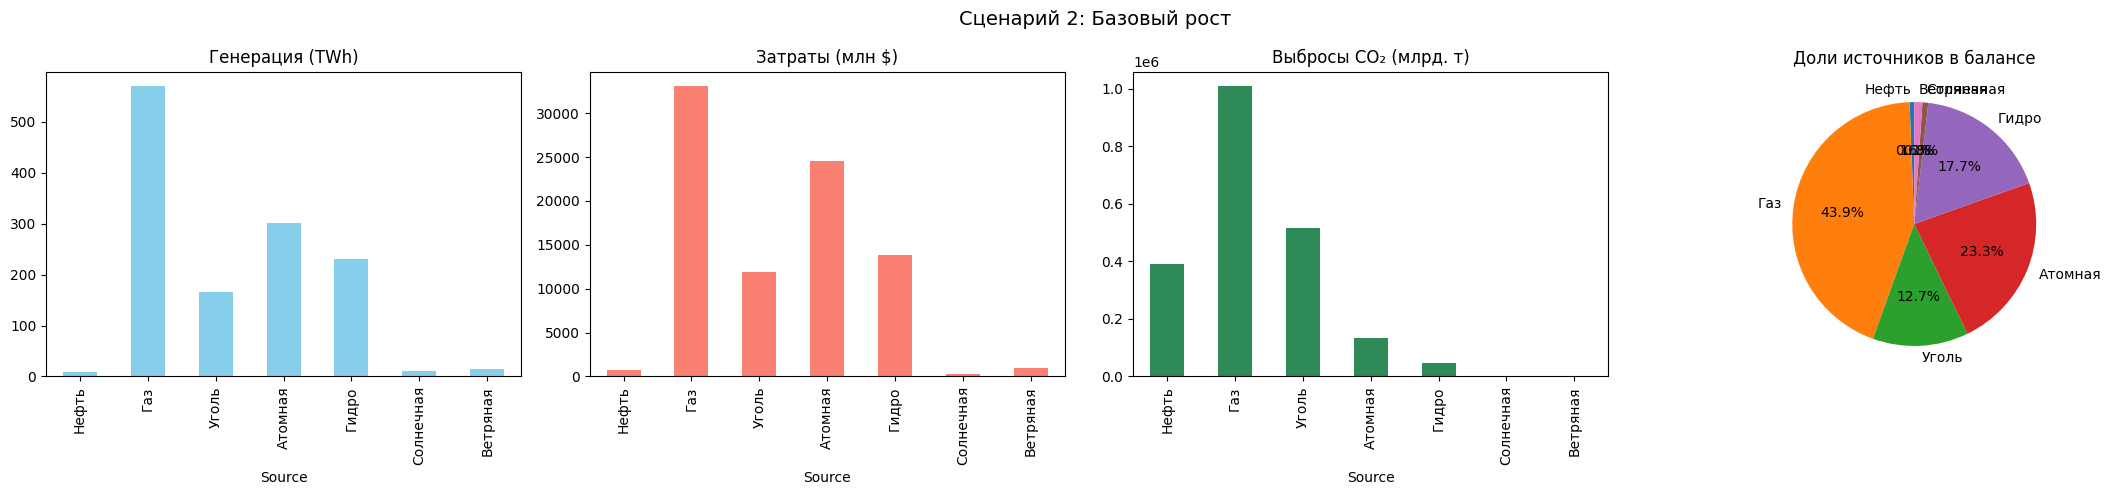


📋 Сценарий 2: Базовый рост
              TWh  Cost (MEUR)  Share (%)
Source                                   
Нефть        8.00       704.00       0.62
Газ        570.52     33090.27      43.89
Уголь      165.00     11880.00      12.69
Атомная    302.48     24500.72      23.27
Гидро      230.00     13800.00      17.69
Солнечная   10.00       320.00       0.77
Ветряная    14.00       938.00       1.08


C:\Users\fal23\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulp\pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


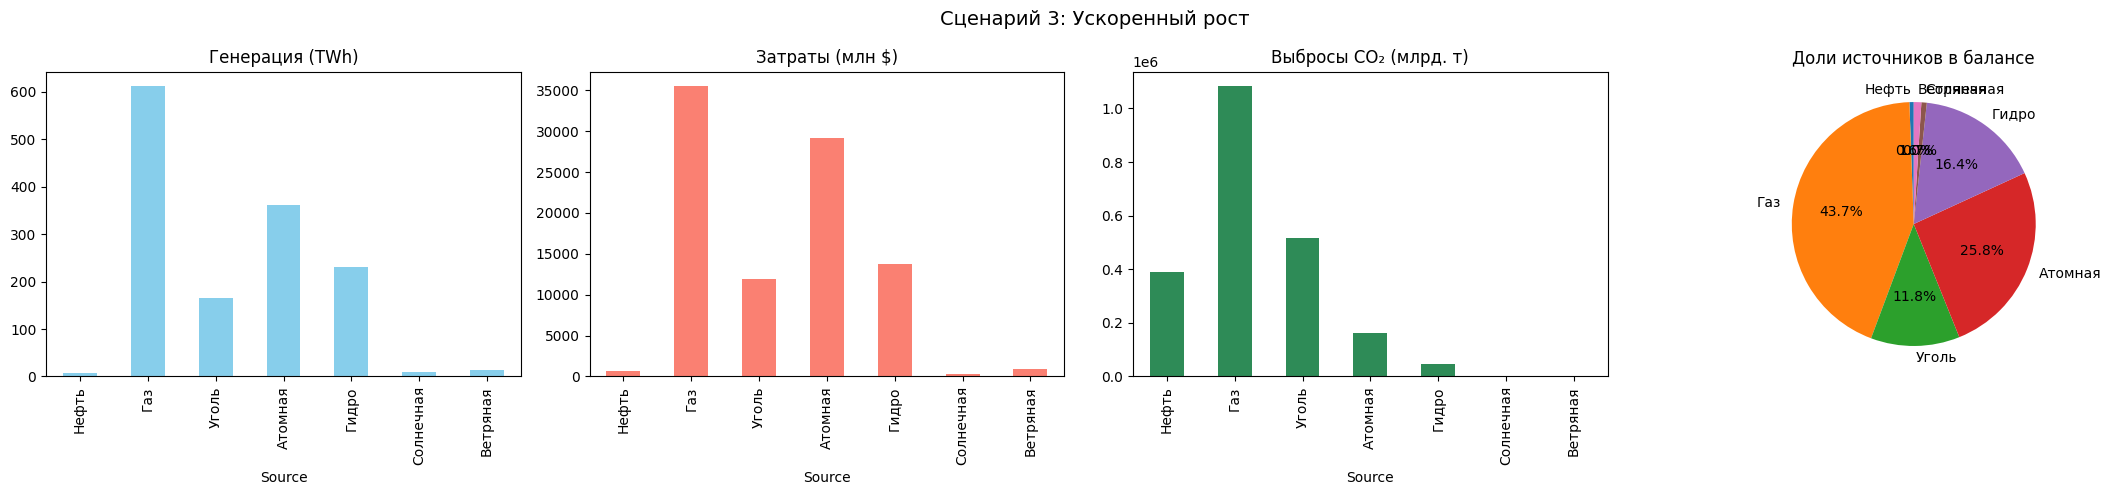


📋 Сценарий 3: Ускоренный рост
              TWh  Cost (MEUR)  Share (%)
Source                                   
Нефть        8.00       704.00       0.57
Газ        612.33     35515.35      43.74
Уголь      165.00     11880.00      11.79
Атомная    360.67     29213.98      25.76
Гидро      230.00     13800.00      16.43
Солнечная   10.00       320.00       0.71
Ветряная    14.00       938.00       1.00

📊 Итоговая сводка по всем сценариям:
                             Объем спроса (TWh)  Суммарные затраты (млрд $)  \
Сценарий 1: Падение спроса               1150.0                    74459.54   
Сценарий 2: Базовый рост                 1300.0                    85233.00   
Сценарий 3: Ускоренный рост              1400.0                    92371.33   

                             Суммарные выбросы (млрд т CO₂)  \
Сценарий 1: Падение спроса                       2000000.01   
Сценарий 2: Базовый рост                         2100000.00   
Сценарий 3: Ускоренный рост                    

In [79]:
import pulp
import matplotlib.pyplot as plt
import pandas as pd

# Источники в России
sources = {
    "Нефть":     {"min": 8,   "max": 10,  "cost": 88.0,  "emission": 414200.00/8.5},
    "Газ":     {"min": 513, "max": 700, "cost": 58.0,  "emission": 907800.00/513.0},
    "Уголь":    {"min": 165, "max": 230, "cost": 72.0,  "emission": 517700.00/165.0},
    "Атомная": {"min": 217, "max": 295, "cost": 81.0,  "emission": 97000.00/217.0},
    "Гидро":   {"min": 198, "max": 230, "cost": 60.0,  "emission": 41000.00/198.0},
    "Солнечная":   {"min": 3,   "max": 10,   "cost": 32.0,  "emission": 9.85/2.7},
    "Ветряная":    {"min": 8,   "max": 14,  "cost": 67.0,  "emission": 1.42/7.6}
}
renewables = ["Hydro", "Solar", "Wind"]

# Сценарии: спрос и лимиты выбросов в TWh и kt CO2
scenarios = {
    "Сценарий 1: Падение спроса":    {"demand": 1150, "emission_limit": 2000000},
    "Сценарий 2: Базовый рост":      {"demand": 1300, "emission_limit": 2100000},
    "Сценарий 3: Ускоренный рост":   {"demand": 1400, "emission_limit": 2200000}
}

results = {}

for name, params in scenarios.items():
    demand = params["demand"]
    emission_limit = params["emission_limit"]

    # LP-модель
    model = pulp.LpProblem(name, pulp.LpMinimize)
    prod = {s: pulp.LpVariable(s, lowBound=sources[s]["min"], upBound=sources[s]["max"]) for s in sources}

    # Целевая функция
    model += pulp.lpSum(prod[s] * sources[s]["cost"] for s in sources)

    # Ограничения
    model += pulp.lpSum(prod[s] for s in sources) >= demand
   # model += pulp.lpSum(prod[s] for s in renewables) >= 0.2 * demand
    model += pulp.lpSum(prod[s] * sources[s]["emission"] for s in sources) <= emission_limit

    model.solve()

    # Результаты
    df = pd.DataFrame([
        {
            "Source": s,
            "TWh": prod[s].varValue or 0,
            "Emissions (kt)": (prod[s].varValue or 0) * sources[s]["emission"],
            "Cost (MEUR)": (prod[s].varValue or 0) * sources[s]["cost"]
        }
        for s in sources
    ])

    df.set_index("Source", inplace=True)
    df["€/MWh"] = df["Cost (MEUR)"] / df["TWh"] * 1000
    df["Share (%)"] = df["TWh"] / demand * 100  # 👉 добавлено
    total = df.sum()

    results[name] = {
        "df": df,
        "total_cost": total["Cost (MEUR)"],
        "total_emissions": total["Emissions (kt)"],
        "avg_cost": total["Cost (MEUR)"] / demand
    }

    # Визуализация
    fig, ax = plt.subplots(1, 4, figsize=(22, 5))

    df["TWh"].plot(kind="bar", ax=ax[0], title="Генерация (TWh)", color="skyblue")
    df["Cost (MEUR)"].plot(kind="bar", ax=ax[1], title="Затраты (млн $)", color="salmon")
    df["Emissions (kt)"].plot(kind="bar", ax=ax[2], title="Выбросы CO₂ (млрд. т)", color="seagreen")

    df["TWh"].plot(kind="pie", ax=ax[3], autopct='%1.1f%%', startangle=90, legend=False)
    ax[3].set_ylabel('')
    ax[3].set_title("Доли источников в балансе")

    for a in ax[:3]: a.set_ylabel("")
    plt.suptitle(name, fontsize=14)
    plt.tight_layout()
    plt.show()

    # Печать табличных результатов
    print(f"\n📋 {name}")
    print(df[["TWh", "Cost (MEUR)", "Share (%)"]].round(2))  # 👉 обновлено

# Итоговая таблица по всем сценариям
summary = pd.DataFrame({
    name: {
        "Объем спроса (TWh)": params["demand"],
        "Суммарные затраты (млрд $)": res["total_cost"],
        "Суммарные выбросы (млрд т CO₂)": res["total_emissions"],
        "Средняя стоимость ($/TWh)": res["avg_cost"]
    }
    for (name, params), res in zip(scenarios.items(), results.values())  # ✅ исправлено
}).T

print("\n📊 Итоговая сводка по всем сценариям:")
print(summary.round(2))

